In [2]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
np.random.seed(101)

2024-04-23 13:42:01.499688: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 13:42:01.499795: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 13:42:01.645985: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
filelist_trainx = sorted(glob.glob('/kaggle/input/smalldataset/smallDataset/trainx/*.jpg'), key=numericalSort)
X_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

filelist_trainy = sorted(glob.glob('/kaggle/input/smalldataset/smallDataset/trainy/*.png'), key=numericalSort)
Y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

In [5]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

X_train shape: (5000, 224, 224, 3)
Y_train shape: (5000, 224, 224)


In [7]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 101)

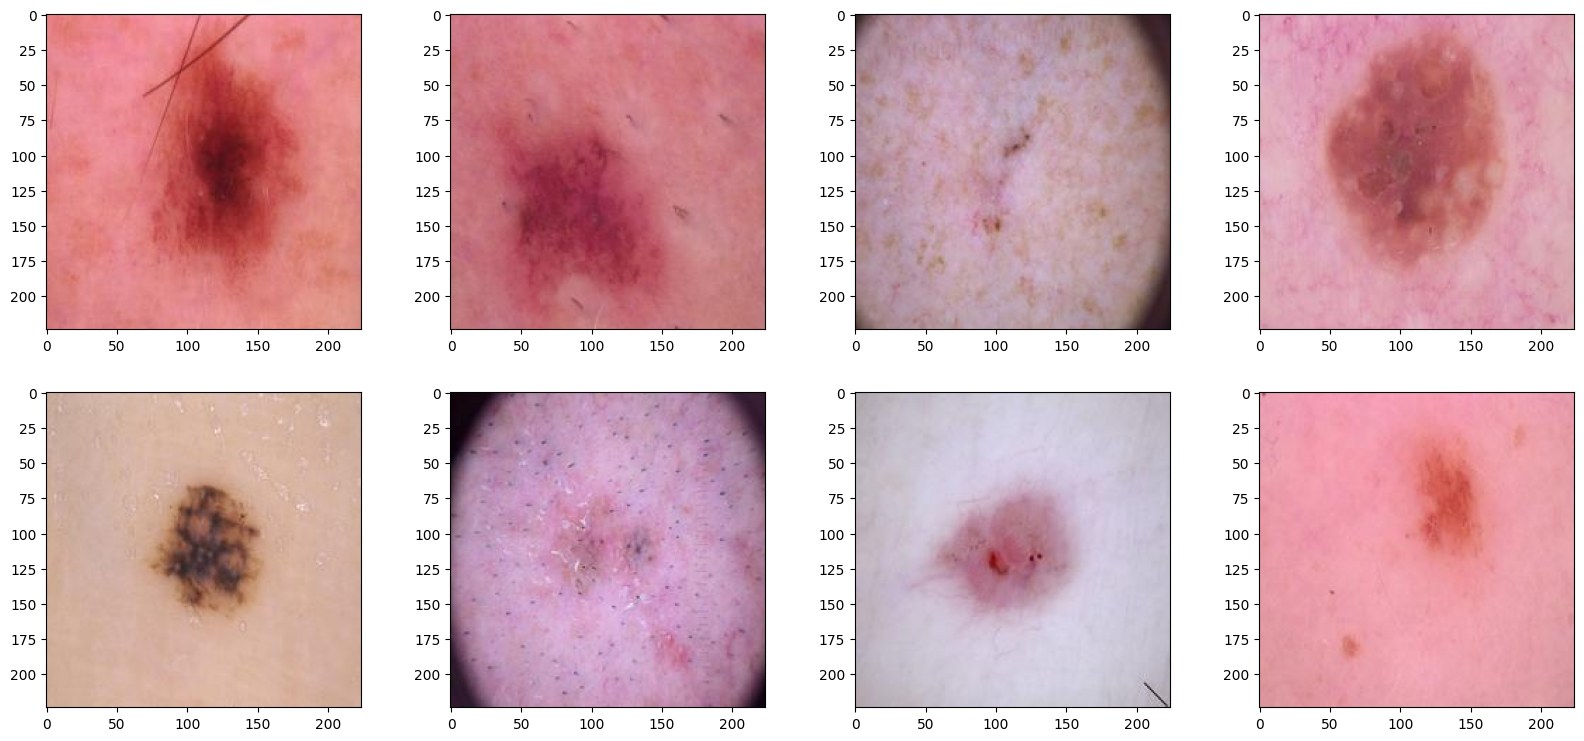

In [7]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(X_train[0])
plt.subplot(2,4,2)
plt.imshow(X_train[3])
plt.subplot(2,4,3)
plt.imshow(X_train[54])
plt.subplot(2,4,4)
plt.imshow(X_train[77])
plt.subplot(2,4,5)
plt.imshow(X_train[100])
plt.subplot(2,4,6)
plt.imshow(X_train[125])
plt.subplot(2,4,7)
plt.imshow(X_train[130])
plt.subplot(2,4,8)
plt.imshow(X_train[149])
plt.show()

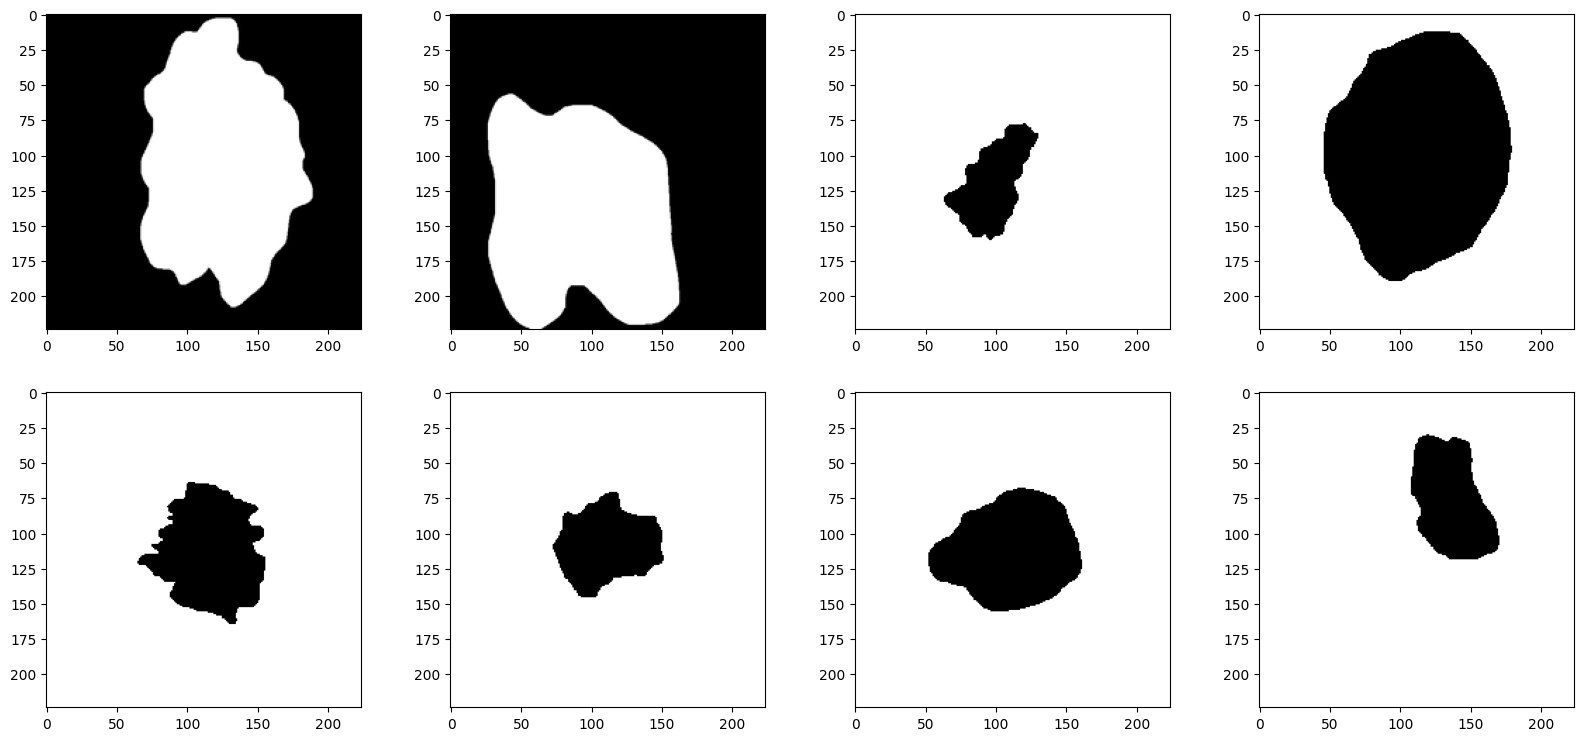

In [8]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(Y_train[0], cmap = plt.cm.binary_r)
plt.subplot(2,4,2)
plt.imshow(Y_train[3], cmap = plt.cm.binary_r)
plt.subplot(2,4,3)
plt.imshow(Y_train[54], cmap = plt.cm.binary_r)
plt.subplot(2,4,4)
plt.imshow(Y_train[77], cmap = plt.cm.binary_r)
plt.subplot(2,4,5)
plt.imshow(Y_train[100], cmap = plt.cm.binary_r)
plt.subplot(2,4,6)
plt.imshow(Y_train[125], cmap = plt.cm.binary_r)
plt.subplot(2,4,7)
plt.imshow(Y_train[130], cmap = plt.cm.binary_r)
plt.subplot(2,4,8)
plt.imshow(Y_train[149], cmap = plt.cm.binary_r)
plt.show()

In [8]:
def jaccard_distance(y_true, y_pred, smooth=100):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

In [9]:
def iou(y_true, y_pred, smooth = 100):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [10]:
def dice_coe(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [11]:

def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [12]:
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [13]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [14]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.20, random_state = 101)

In [21]:
print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(x_test)))
print("Length of the Validation Set : {}".format(len(x_val)))

Length of the Training Set   : 4000
Length of the Test Set       : 1250
Length of the Validation Set : 1000


In [16]:
# Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
INPUT_CHANNELS = 3
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1
# Pretrained weights

In [17]:

def double_conv_layer(x, size, dropout=0.40, batch_norm=True):
    if K.image_data_format() == 'channels_first':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv


def UNET_224(epochs_num, savename):
    dropout_val=0.50
    if K.image_data_format() == 'channels_first':
        inputs = Input((INPUT_CHANNELS, 224, 224))
        axis = 1
    else:
        inputs = Input((224, 224, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)
    pred = Reshape((224,224))(conv_final)
    model = Model(inputs, pred, name="UNET_224")
    model.compile(optimizer= Adam(learning_rate = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coe, precision, recall, accuracy])
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 18,validation_data=(x_val, y_val), verbose=1)
    model.save('/kaggle/working/' + savename)
    return model, hist

In [18]:
model, hist = UNET_224(1, 'unet_1_epoch.h5')

Model: "UNET_224"

 Trainable params: 31,454,721 (119.99 MB)

 Non-trainable params: 12,032 (47.00 KB)

2024-04-23 13:43:31.781114: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100352: 4.85241, expected 3.99591
2024-04-23 13:43:31.781177: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100353: 7.11791, expected 6.26141
2024-04-23 13:43:31.781186: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100354: 7.22171, expected 6.36521
2024-04-23 13:43:31.781194: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100355: 6.92082, expected 6.06432
2024-04-23 13:43:31.781202: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100356: 6.65139, expected 5.7949
2024-04-23 13:43:31.781210: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100357: 6.62069, expected 5.7642
2024-04-23 13:43:31.781217: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100358: 6.58323, expected 5.72673
2024-04-23 13:43:31.78

222/223 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.6066 - dice_coe: 0.7920 - iou: 0.3201 - loss: 0.6799 - precision: 1.8646 - recall: 0.9753

2024-04-23 13:45:01.844824: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.27163, expected 3.68847
2024-04-23 13:45:01.844889: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.66001, expected 4.07686
2024-04-23 13:45:01.844905: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.99414, expected 3.41098
2024-04-23 13:45:01.844921: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 4.62205, expected 4.03889
2024-04-23 13:45:01.844941: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 4.06311, expected 3.47995
2024-04-23 13:45:01.844956: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 62: 4.7913, expected 4.20815
2024-04-23 13:45:01.844969: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 4.23189, expected 3.64874
2024-04-23 13:45:01.844981: E external/local_xla/x

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.6067 - dice_coe: 0.7915 - iou: 0.3201 - loss: 0.6799 - precision: 1.8656 - recall: 0.9752

2024-04-23 13:45:33.302050: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.44023, expected 3.56217
2024-04-23 13:45:33.302110: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.72784, expected 5.84979
2024-04-23 13:45:33.302120: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 7.1489, expected 6.27084
2024-04-23 13:45:33.302128: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 7.06006, expected 6.182
2024-04-23 13:45:33.302135: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.53803, expected 5.65998
2024-04-23 13:45:33.302143: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 7.15196, expected 6.27391
2024-04-23 13:45:33.302150: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.05401, expected 5.17595
2024-04-23 13:45:33.302157: E external/local_xla/xla/servi

223/223 ━━━━━━━━━━━━━━━━━━━━ 155s 391ms/step - accuracy: 0.6068 - dice_coe: 0.7909 - iou: 0.3202 - loss: 0.6798 - precision: 1.8666 - recall: 0.9751 - val_accuracy: 0.5577 - val_dice_coe: 1.0263 - val_iou: 0.3214 - val_loss: 0.6786 - val_precision: 1.1511 - val_recall: 0.9815


In [19]:
model, hist = UNET_224(epochs_num= 100, savename= 'unet_100_epoch.h5')

Model: "UNET_224"

 Trainable params: 31,454,721 (119.99 MB)

 Non-trainable params: 12,032 (47.00 KB)

Epoch 1/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 118s 341ms/step - accuracy: 0.6322 - dice_coe: 0.6084 - iou: 0.3240 - loss: 0.6760 - precision: 3.0016 - recall: 0.9617 - val_accuracy: 0.5539 - val_dice_coe: 0.9382 - val_iou: 0.3224 - val_loss: 0.6776 - val_precision: 1.2114 - val_recall: 0.9805
Epoch 2/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step - accuracy: 0.6604 - dice_coe: 0.3787 - iou: 0.3388 - loss: 0.6612 - precision: 3.6396 - recall: 0.7967 - val_accuracy: 0.6447 - val_dice_coe: 0.3702 - val_iou: 0.3264 - val_loss: 0.6736 - val_precision: 2.1264 - val_recall: 0.5239
Epoch 3/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step - accuracy: 0.6599 - dice_coe: 0.2714 - iou: 0.3377 - loss: 0.6623 - precision: 4.7648 - recall: 0.7198 - val_accuracy: 0.6616 - val_dice_coe: 0.1774 - val_iou: 0.3268 - val_loss: 0.6732 - val_precision: 5.7830 - val_recall: 0.5371
Epoch 4/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 82s 185ms/step - accuracy: 0.6681 - dice_coe: 0.3215 - iou: 0.3413 - loss: 0.6587 - precision:

In [22]:
dropout_val=0.50
if K.image_data_format() == 'channels_first':
    inputs = Input((INPUT_CHANNELS, 224, 224))
    axis = 1
else:
    inputs = Input((224, 224, INPUT_CHANNELS))
    axis = 3
filters = 32

conv_224 = double_conv_layer(inputs, filters)
pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

conv_112 = double_conv_layer(pool_112, 2*filters)
pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

conv_56 = double_conv_layer(pool_56, 4*filters)
pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

conv_28 = double_conv_layer(pool_28, 8*filters)
pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

conv_14 = double_conv_layer(pool_14, 16*filters)
pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

conv_7 = double_conv_layer(pool_7, 32*filters)

up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
up_conv_14 = double_conv_layer(up_14, 16*filters)

up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
up_conv_28 = double_conv_layer(up_28, 8*filters)

up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
up_conv_56 = double_conv_layer(up_56, 4*filters)

up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
up_conv_112 = double_conv_layer(up_112, 2*filters)

up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
conv_final = Activation('sigmoid')(conv_final)
pred = Reshape((224,224))(conv_final)


In [23]:
model_1 = Model(inputs, pred, name="UNET_224")
model_1.compile(optimizer= Adam(learning_rate = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coe, precision, recall, accuracy])

In [24]:
model_1.load_weights('/kaggle/working/unet_100_epoch.h5')

In [25]:

print('\n~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_1.evaluate(x_train, y_train, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_1.evaluate(x_test, y_test, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_1.evaluate(x_val, y_val, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

223/223 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.5559 - dice_coe: 1.3339 - iou: 0.3376 - loss: 0.6624 - precision: 0.7043 - recall: 0.7319
________________________
IOU:       |   34.13  |
Dice Coef: |   134.21  |
Precision: |   70.64  |
Recall:    |   73.56  |
Accuracy:  |   55.91  |
Loss:      |   65.87  |
________________________

-------------On Test  Set--------------------------

69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5395 - dice_coe: 1.2694 - iou: 0.3201 - loss: 0.6799 - precision: 0.6984 - recall: 0.7028

2024-04-23 15:01:38.119101: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.75204, expected 2.80617
2024-04-23 15:01:38.119160: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.5929, expected 3.64702
2024-04-23 15:01:38.119170: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.49398, expected 4.54811
2024-04-23 15:01:38.119177: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.96573, expected 4.01986
2024-04-23 15:01:38.119185: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.20058, expected 3.25471
2024-04-23 15:01:38.119192: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.83434, expected 4.88847
2024-04-23 15:01:38.119200: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.77851, expected 3.83264
2024-04-23 15:01:38.119207: E external/local_xla/xla/ser

70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.5398 - dice_coe: 1.2708 - iou: 0.3204 - loss: 0.6796 - precision: 0.6983 - recall: 0.7034
________________________
IOU:       |   32.99  |
Dice Coef: |   131.94  |
Precision: |   69.57  |
Recall:    |   72.57  |
Accuracy:  |   55.14  |
Loss:      |   67.01  |
________________________

-------------On validation Set---------------------

56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.5370 - dice_coe: 1.2587 - iou: 0.3180 - loss: 0.6820 - precision: 0.6991 - recall: 0.6978
________________________
IOU:       |   32.84  |
Dice Coef: |   132.25  |
Precision: |   69.68  |
Recall:    |   72.73  |
Accuracy:  |   55.07  |
Loss:      |   67.16  |
________________________


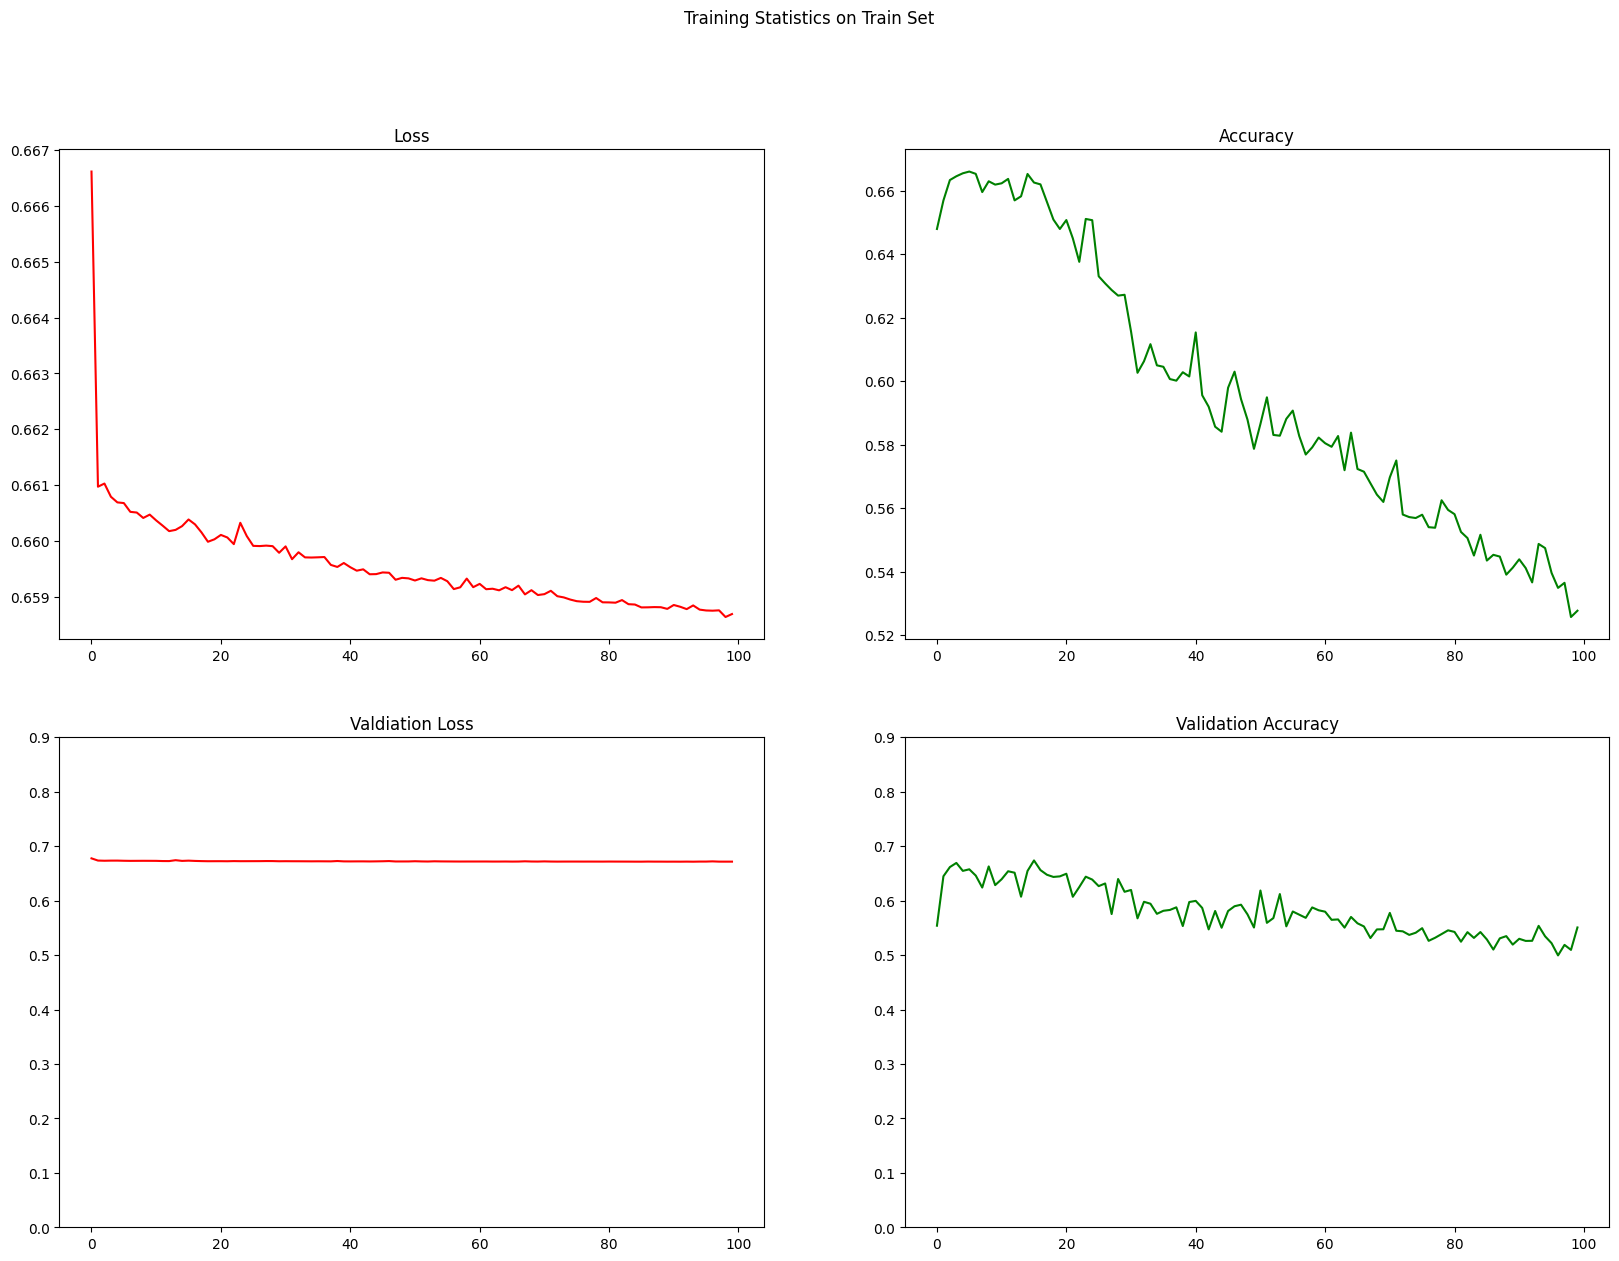

In [26]:
plt.figure(figsize=(20, 14))
plt.suptitle('Training Statistics on Train Set')
plt.subplot(2,2,1)
plt.plot(hist.history['loss'], 'red')
plt.title('Loss')
plt.subplot(2,2,2)
plt.plot(hist.history['accuracy'], 'green')
plt.title('Accuracy')
plt.subplot(2,2,3)
plt.plot(hist.history['val_loss'], 'red')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Valdiation Loss')
plt.subplot(2,2,4)
plt.plot(hist.history['val_accuracy'], 'green')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Validation Accuracy')
plt.show()

2024-04-23 15:03:14.151827: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 2.72318, expected 2.22985
2024-04-23 15:03:14.151884: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 3.38867, expected 2.89534
2024-04-23 15:03:14.151894: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 3.47311, expected 2.97978
2024-04-23 15:03:14.151902: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64: 3.51732, expected 3.02399
2024-04-23 15:03:14.151909: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 67: 3.87081, expected 3.37748
2024-04-23 15:03:14.151917: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 83: 3.19173, expected 2.69841
2024-04-23 15:03:14.151924: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 84: 3.54129, expected 3.04796
2024-04-23 15:03:14.151932: E external/local_xla

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


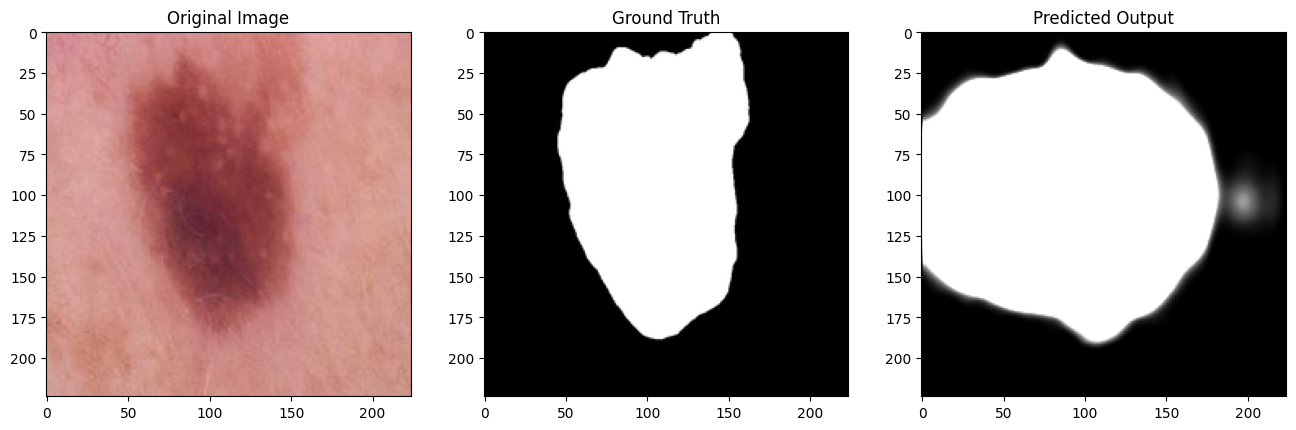

In [27]:
img_num = 49
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224, 224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


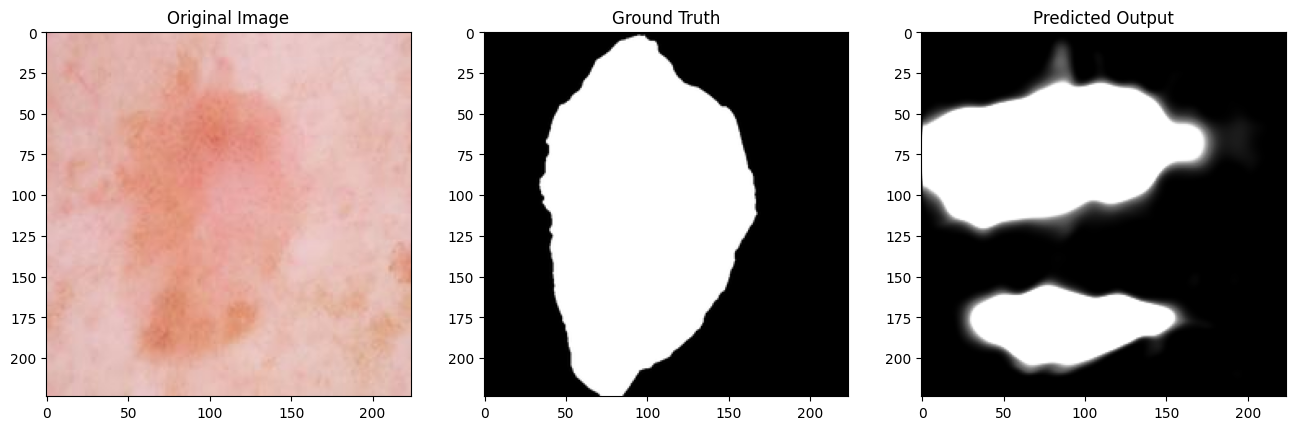

In [28]:
img_num = 1000
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


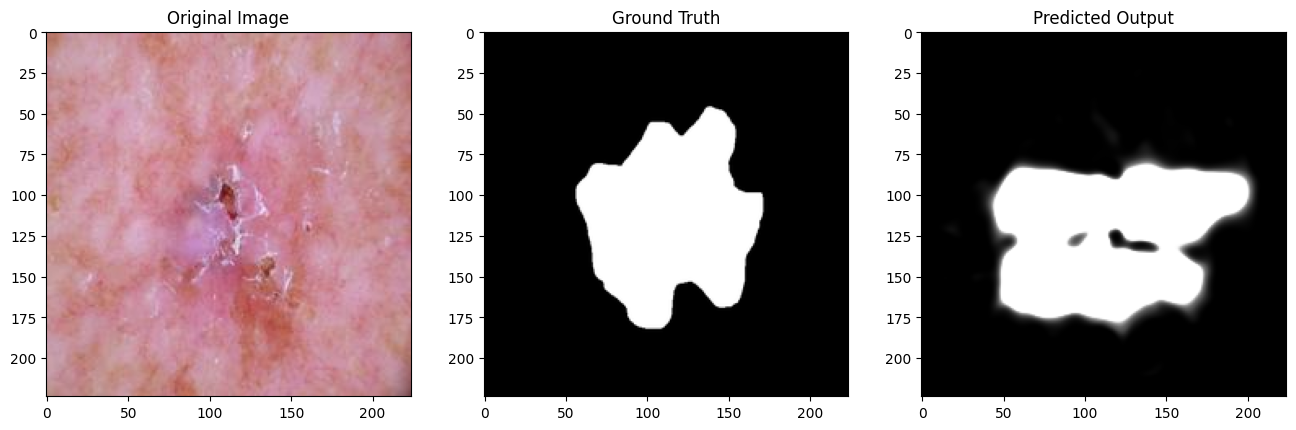

In [33]:
img_num = 540
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


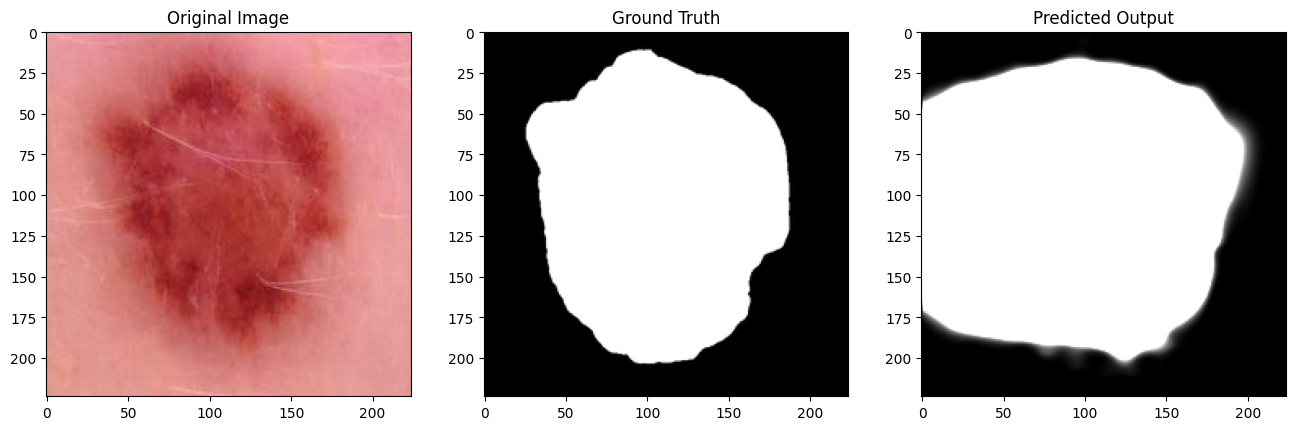

In [30]:
img_num = 325
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


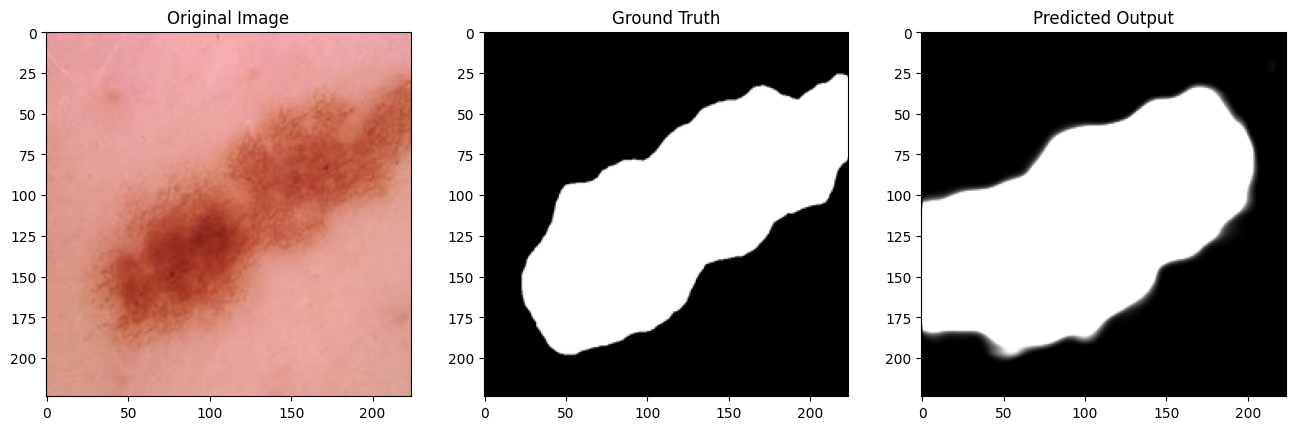

In [35]:
img_num = 1150
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


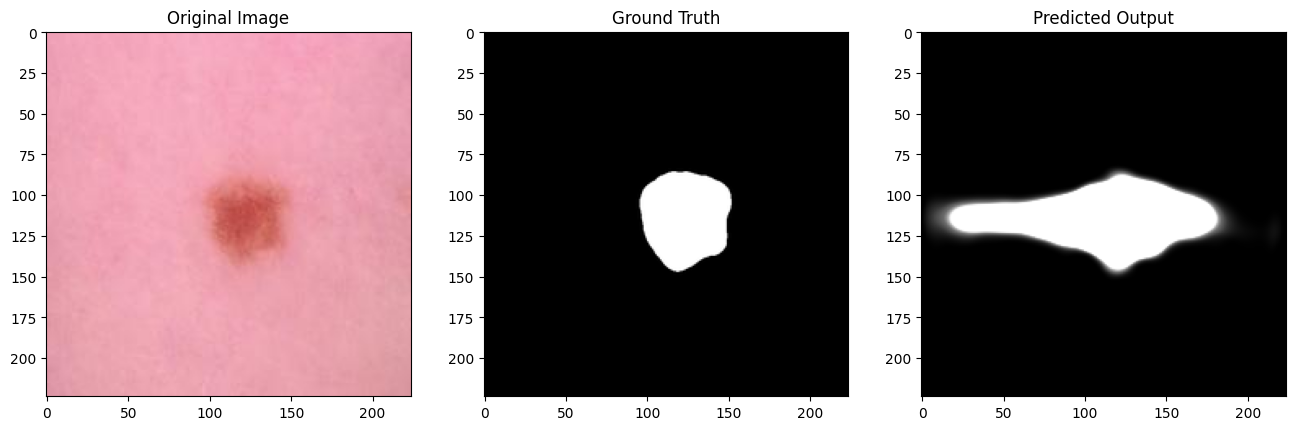

In [36]:
img_num = 218
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

In [37]:
def enhance(img):
    sub = (model_1.predict(img.reshape(1,224,224,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


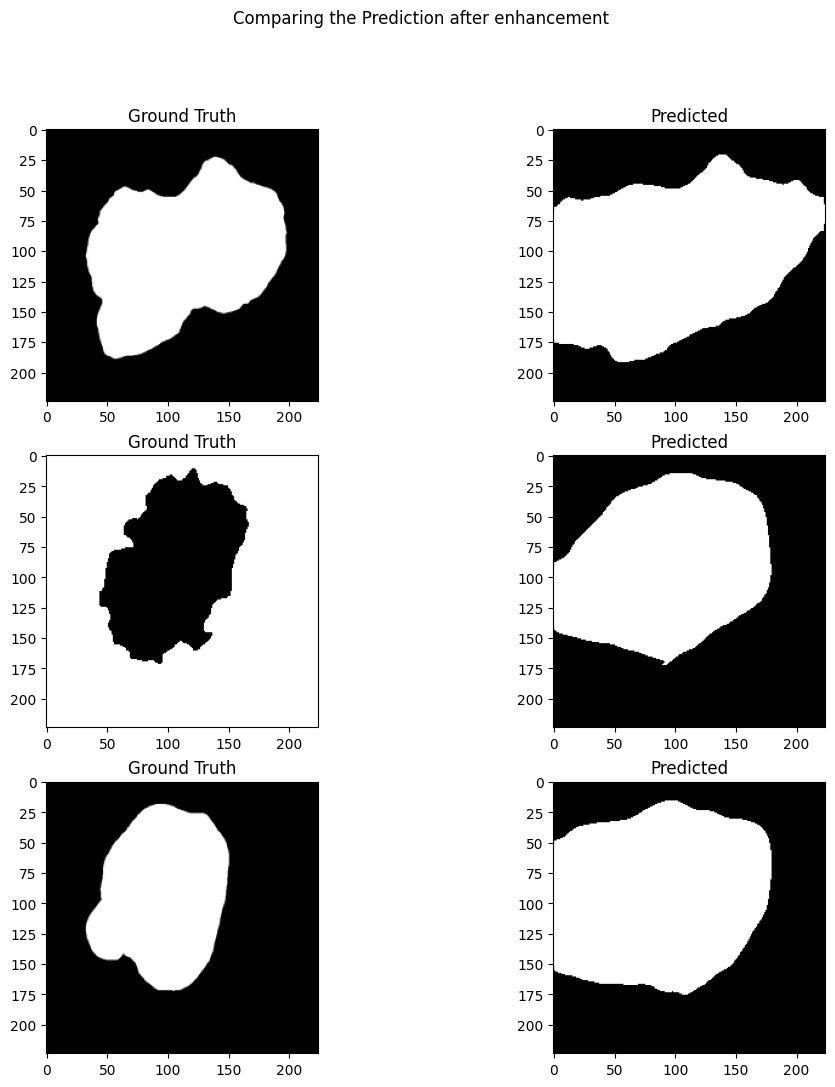

In [38]:
plt.figure(figsize=(12,12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(y_test[21],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(enhance(x_test[21]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,3)
plt.imshow(y_test[47],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,4)
plt.imshow(enhance(x_test[47]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,5)
plt.imshow(y_test[36],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,6)
plt.imshow(enhance(x_test[36]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')
plt.show()